# Inspect source light curves and skymaps

### Setup main notebook options

In [1]:
region_name = "ALL_10-800_LOOSE"  #"TDS" #"CAINGSGII_10-800"  #"TDS" #"WD" #"MDIS_10-800" # "TDS_ELAISN1"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"
show_skymaps = False
show_sed = True
force_show_LS = False
load_src_from_file = True
lc_block_srcs = 5 #Setup light curve plotting parameters

srcs_ids = []
srcs_ids = [4993 ,13580 ,14504 ,30475 ,50388 ,52994 ,79477 ,120265 ,138783 ,139480 ,162697 ,204419 ,221349 ,228958 ,236839 ,253214 ,253670
            ,256433 ,261213 ,331466 ,340464 ,381336 ,390864 ,489430 ,498065 ,525310 ,532554 ,533185 ,540235 ,583838 ,639720 ,645215 ,645730
            ,659787 ,666224 ,673175 ,680119 ,691408 ,714140 ,764827 ,1037284 ,1069077 ,1070938 ,1805505 ,1839206 ,2527679 ,3074917 ,] # WD ALL_10-800-LOOSE
#srcs_ids = [4993,14504,52994,120265,221349,236839,381336,525310,533185,639720,666224,673175,680119,1070938] # # WD ALL_10-800-LOOSE BB SED# Additional candidates 139480,204419,532554,659787,79477,,253214
srcs_ids = [14504,52994,221349,639720,666224]  # # WD ALL_10-800-LOOSE BB SED, gphot agree
#srcs_ids = [193067 ,432606 ,535864 ,451644 ,1551422 ,541266 ,581995 ,625693 ,187856 ,8215 ,494782 ,166179 ,172775 ,34658 ,98746 ,
#            1521738 ,2136829 ,297278 ,426363 ,426330 ,151796 ,305192 ,259271 ,388172 ,265150 ,54184 ,472623 ,419001 ,25273 ,26195 ,32448 ,199832 ,]# WD ALL_10-800

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from regions import CircleSkyRegion
from astropy import units as uu
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import Table
import numpy as np

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from vasca.utils import mag2flux, sel_sources, dd_filter2id

from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord

#Load region
rg = Region()
rg.load_from_fits(region_fname)

print("Nr sources:",len(rg.tt_sources),"selected:",rg.tt_sources["sel"].sum())
    
#Subselect sources based on choice
if len(srcs_ids)>0:
    rg.tt_sources.add_index("rg_src_id")
    idx_srcs = rg.tt_sources.loc_indices["rg_src_id", srcs_ids]
    tt_srcs = Table(rg.tt_sources[idx_srcs])
else:
    tt_srcs = rg.tt_sources

nr_srcs = len(tt_srcs)
tt_srcs.add_index("rg_src_id")
#display(tt_srcs)

Nr sources: 10413 selected: 10413


### Show all info for one source

In [3]:
#Define displayed tables and columns
disp_tt_sources = ['ra','dec','rg_src_id','flux_cpval','flux',"flux_ne",'nr_det','pos_err','pos_xv','pos_cpval','pos_rchiq','coadd_src_id','coadd_dist','obs_filter_id','flux_err','flux_nxv','flux_rchiq','coadd_ffactor',
                   'coadd_fdiff_s2n','nr_fd_srcs','hr','hr_err','gfcat_src_id'] #'fd_src_id','rg_fd_id,,'pos_var','flux_var','sel', ,'simbad_match_id','gaiadr3_match_id', 'gfcat_dist'
disp_tt_simbad = ['ogrp','otypes','main_id','otype','sp_type','sp_bibcode','ra','dec','ra_prec','dec_prec','coo_err_maja','coo_err_mina','coo_err_angle','coo_qual','coo_wavelength','coo_bibcode','distance_distance','distance_q','distance_unit',
                  'distance_merr','distance_perr','distance_method','distance_bibcode','match_distance','rvz_type','rvz_radvel','rvz_error','rvz_qual','rvz_wavelength','rvz_bibcode','z_value','sp_qual','simbad_match_id'] #,'rg_src_id',,'script_number_id'
disp_tt_gaiadr3 = ['ogrp',"Plx_dist","VarFlag", "o_Gmag",'Gmag_abs','BP-RP','ra','dec','Source','e_RA_ICRS','e_DE_ICRS','Plx','e_Plx','PM','pmRA','e_pmRA','pmDE','e_pmDE','RUWE','FG','e_FG','Gmag','FBP','e_FBP','BPmag','FRP','e_FRP','RPmag','RV','e_RV',
                   'Vbroad','GRVSmag','QSO','Gal','NSS','XPcont','XPsamp','RVS','EpochPh','EpochRV','MCMCGSP','MCMCMSC','And','Teff','logg','__Fe_H_','Dist','A0','HIP','PS1','SDSS13','SKYM2','TYC2','URAT1','AllWISE','APASS9',
                   'GSC23','RAVE5','_2MASS','RAVE6','RAJ2000','DEJ2000','PQSO','PGal','PSS','RPlx','match_distance','gaiadr3_match_id'] #,'_q',,'rg_src_id'
dd_tab_col = {"tt_sources":disp_tt_sources, "tt_simbad":disp_tt_simbad, "tt_gaiadr3":disp_tt_gaiadr3, "tt_fields":[],"tt_gphoton_stats":[], "tt_gphoton_lc":[]}


def display_src_info(rg_src_id=0):

    #Get source
    tc_src = rg.get_src_from_id(rg_src_id, load_from_file = load_src_from_file, add_sed=show_sed,add_gphoton=False, add_spectrum=show_sed)

    #Prepare figure

    fig, ax = plt.subplots(1,1,figsize=(18, 6),squeeze=True, num="LC source ID " + str(rg_src_id), clear=True) #, gridspec_kw={'width_ratios': [2, 1]}
    _ = vvis.plot_light_curve(tc_src, ax = ax)
    plt.show()
    #axs = axs.flatten()
    
    #Plot light curve und SED
     #
    if show_sed:
        fig, ax = plt.subplots(1,1,figsize=(12, 8),squeeze=True, num="Spec source ID " + str(rg_src_id), clear=True) 
        _ = vvis.plot_sed(tc_src,ax = ax)
    plt.show()

    #If lomb scargle present and signal is at more than 3 sigma plot it too
    show_LS = "tt_lombscargle" in tc_src._table_names and tc_src.tt_lombscargle["ls_peak_pval"] < 0.002699796063
    if force_show_LS or show_LS:
        fig_ls, axs_ls = plt.subplots(2,2,figsize=(15, 10),squeeze=True, num="LS " + str(rg_src_id), clear=True)
        axs_ls = axs_ls.flatten()
        vvis.plot_lombscargle(tc_src.tt_source_lc, ax=axs_ls[0], ax_phase = axs_ls[1]) #, ax_lc = axs[0]
        vvis.plot_lombscargle(tc_src.tt_source_lc, ax=axs_ls[2],obs_filter="FUV", ax_phase = axs_ls[3])
        plt.show()
        if "tt_lombscargle" in tc_src._table_names:
            print("\n tt_lombscargle :")
            display(tc_src.tt_lombscargle)

    for table_name, col_names in dd_tab_col.items():
        if table_name in tc_src._table_names:
            print("\n",table_name,":")
            if len(col_names)==0:
                display(tc_src.__dict__[table_name])
            else:
                display(tc_src.__dict__[table_name][col_names])
    
    #tc_src.tt_sed.pprint_all()

widgets.interactive(display_src_info, rg_src_id=tt_srcs["rg_src_id"])
#2572986 specially clear example

interactive(children=(Dropdown(description='rg_src_id', options=(14504, 52994, 221349, 639720, 666224), value=…

### Draw light curves

interactive(children=(IntSlider(value=0, description='block_nr', max=1), Output()), _dom_classes=('widget-inte…

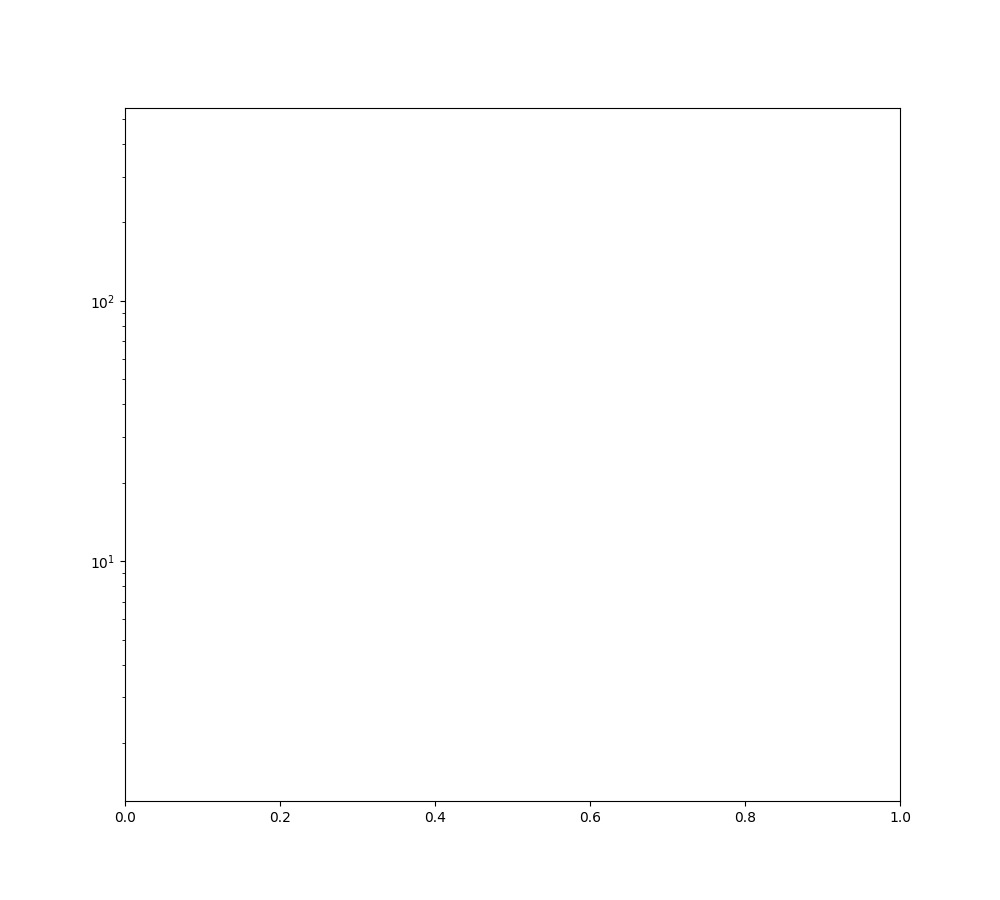

In [4]:
nr_blocks = int(nr_srcs/lc_block_srcs)+1 
def plot_lc_range(block_nr):
    fig_lc = plt.figure("Light curves",figsize=(10, 9), clear=True)
    lc_min = lc_block_srcs * block_nr
    lc_max = lc_min + lc_block_srcs if lc_min + lc_block_srcs<=nr_srcs-1 else nr_srcs
    vvis.plot_light_curves(rg,fig=fig_lc, rg_src_ids = tt_srcs["rg_src_id"][lc_min:lc_max], ylim = [1.2,550])
    plt.show()
    #display(tt_srcs[lc_min:lc_max]) #[show_lc_pars]
widgets.interactive( plot_lc_range, block_nr=(0,nr_blocks-1))

### Plot skymaps for one source

In [5]:
def plot_sky_src(rg_src_id=0, fd_idx=0, vis_idx = -1):
    
    #Check if src_id exists
    if rg_src_id not in tt_srcs["rg_src_id"]:
        print("Source ID does not exist") 
        return
    
    #Get source and check id field index out of range
    tc_src = rg.get_src_from_id(rg_src_id)
    if fd_idx > len(tc_src.tt_fields)-1:
        print("Field index out of range") 
        return
    
    #Get field to plot and check if visit index out of range
    rg_fd_id = tc_src.tt_fields[fd_idx]["rg_fd_id"]
    fd_src = rg.get_field(rg_fd_id=rg_fd_id, load_method="FITS", add_field=True)
    if vis_idx > len(fd_src.tt_visits)-1:
        print("Visit index out of range") 
        return

    fig_src = plt.figure("Sky map source",figsize=(8, 7), clear=True)

    #Get sky region of source
    sky_center = SkyCoord(tc_src.tt_sources[0]["ra"]*uu.deg, tc_src.tt_sources[0]["dec"]*uu.deg, frame="icrs")
    sky_region_src = CircleSkyRegion(center=sky_center, radius=0.3*uu.arcmin)
     
    #Plot
    plt.cla()
    ax_src, wcs_src = vvis.plot_field_sky_map(fd_src, img_idx=vis_idx, sky_region = sky_region_src, fig=fig_src) #
    
    #If displaying visits, onle show detections in that visit
    sel_det_rg = np.ones(len(rg.tt_detections), dtype=bool)
    sel_det_src = np.ones(len(tc_src.tt_detections), dtype=bool)
    
    # Preselt field detections, can be removed in the future
    #fd_src.tt_detections = fd_src.tt_detections[fd_src.tt_detections["s2n"]>0]
    
    sel_det_fd = np.ones(len(fd_src.tt_detections), dtype=bool)
    if vis_idx > -1:
        vis_id = fd_src.tt_visits["vis_id"][vis_idx]
        sel_det_rg = (rg.tt_detections["vis_id"]==vis_id) * (rg.tt_detections["obs_filter_id"]==dd_filter2id[fd_src.obs_filter])
        sel_det_src = (tc_src.tt_detections["vis_id"]==vis_id) * (tc_src.tt_detections["obs_filter_id"]==dd_filter2id[fd_src.obs_filter])

        fd_det_coords = SkyCoord(fd_src.tt_detections["ra"][sel_det_fd], fd_src.tt_detections["dec"][sel_det_fd], frame="icrs")
        sel_det_fd = ( (fd_src.tt_detections["vis_id"] == vis_id)
                     * (fd_src.tt_detections["obs_filter_id"] == dd_filter2id[fd_src.obs_filter])
                     * sky_region_src.contains(fd_det_coords, wcs_src))
        
    #Show sources
    plt_ref_src_kwargs = {"marker": "x","markersize": 10,"color":"yellow"}
    _ = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections[sel_det_rg], sky_region_wcs = (sky_region_src,wcs_src),only_selected=False) #
    _ = vvis.plot_sky_sources(rg.tt_coadd_sources,tt_det=None, sky_region_wcs = (sky_region_src,wcs_src),only_selected=False, src_id="coadd_src_id", src_kwargs = plt_ref_src_kwargs)
    if vis_idx > -1:
        plot_tds = {"marker":"x","color":"green"}
        _ = vvis.plot_sky_sources(fd_src.tt_detections[sel_det_fd],src_kwargs=plot_tds, sky_region_wcs = (sky_region_src,wcs_src),  src_id="det_id",only_selected=False)
    plt.show()

    # Display sources only for the shown field
    #fd_src_id = rg.tt_src_id_map[sel_fd_src]["fd_src_id"][0]
    if vis_idx > -1:
        print("\nAll detections for this visit in the field:")
        display(fd_src.tt_detections[sel_det_fd])
    
#Decide which sources to show
list_srcs = tt_srcs["rg_src_id"]
if len(srcs_ids)>0:
    list_srcs = srcs_ids

if show_skymaps:
    widget = widgets.interactive( plot_sky_src, rg_src_id=list_srcs,
                        fd_idx=widgets.IntSlider(min=0, max=10, value=0, step=1),
                        vis_idx = widgets.IntSlider(min=-1, max=100, value=-1, step=1)) #visprob_srcids = [1669,1801,2815,3776,4338,6137,] 
    
    controls = widgets.HBox(widget.children[:-1], layout = widgets.Layout(flex_flow='row wrap'))
    output = widget.children[-1]
    display(widgets.VBox([controls, output]))
    # straight NUV, dashed FUV

### Draw sky maps of entire fields

In [6]:
def plot_sky_field(rg_fd_id):
    if rg_fd_id not in rg.tt_fields["rg_fd_id"]:
        print("source ID does not exist") 
        return
    fig_skymap = plt.figure("Sky map",figsize=(9, 8), clear=True) #, constrained_layout=True
    fd = rg.get_field(rg_fd_id=rg_fd_id, load_method="FITS", add_field=True)
    ax, wcs = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region(),fig=fig_skymap) # 
    ax, tt_src_shown = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, sky_region_wcs = (fd.get_sky_region(),wcs),only_selected=True) # 
    plt.show()
    #display(tt_src_shown) #[show_map_pars]
if show_skymaps: 
    widgets.interactive(plot_sky_field, rg_fd_id=rg.tt_fields["rg_fd_id"])

In [7]:
a = np.array([1,2,3])
b = (a%1.5)/1.5
print(a,b)

[1 2 3] [0.66666667 0.33333333 0.        ]


In [8]:
37*1.4997833396927116

55.49198356863033